In [1]:
from symred.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, 
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

# Build the molecule and its Hamiltonian with the Coupled-Cluster operator 

In [3]:
# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms  = mol_data['atoms']
coords = mol_data['coords']
basis  = mol_data['basis'] #'6-31g' #'cc-pVDZ' #
spin   = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis)

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -74.96203967838721
MP2 energy:  -74.99708201366197
CCSD energy: -75.0107316426907
FCI energy:  -75.01084664816946


Number of qubits: 14


Molecular orbital energies:


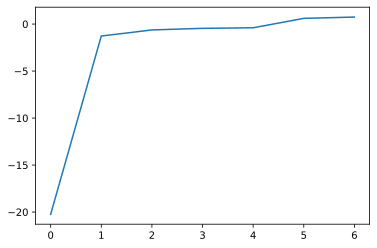

In [4]:
print('Molecular orbital energies:')
plt.plot(molecule.pyscf_obj.pyscf_hf.mo_energy)
plt.show()

# Taper the Hamiltonian

In [5]:
taper_hamiltonian = QubitTapering(molecule.H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
hf_array = molecule.H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIIZZIIZZIIZ 
 1 IZIZIZIZIZIZIZ 
 1 IIIIZZIIIIIIZZ 
 1 IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j IIIIIIIIYZIIII, None), (1.000+0.000j IIIIYZIIIIIIZZ, None), (1.000+0.000j YIZIIZZIIZZIIZ, None), (1.000+0.000j IYIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIII 
-1 IXIIIIIIIIIIII 
-1 IIIIXIIIIIIIII 
-1 IIIIIIIIXIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]
The tapered Hartree-Fock state is  1.0000000000 |1111110000>


/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


# Build the CS-VQE model

In [6]:
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

# Identify stabilizers according to the CC operator

In [7]:
scores = []

for i in range(1, ham_tap.n_qubits):
    CC_stabilizers = StabilizerIdentification(ucc_tap)
    S_CC           = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
    stab_score_CC  = cs_vqe_lw.basis_score(S_CC)
    
    ham_cs = cs_vqe_lw.project_onto_subspace(S_CC)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    error = e-molecule.fci_energy
    print(f'{i}-qubit CS-VQE error is {error:.5f} with stabilizer score {stab_score_CC:.5f}')
    
    scores.append((stab_score_CC, error))

1-qubit CS-VQE error is 0.03641 with stabilizer score 0.34903
2-qubit CS-VQE error is 0.03242 with stabilizer score 0.41627
3-qubit CS-VQE error is 0.02581 with stabilizer score 0.54404
4-qubit CS-VQE error is 0.01753 with stabilizer score 0.71761
5-qubit CS-VQE error is 0.01122 with stabilizer score 0.79470
6-qubit CS-VQE error is 0.00145 with stabilizer score 0.91050
7-qubit CS-VQE error is 0.00041 with stabilizer score 0.95710
8-qubit CS-VQE error is 0.00008 with stabilizer score 0.99991
9-qubit CS-VQE error is 0.00005 with stabilizer score 0.99994


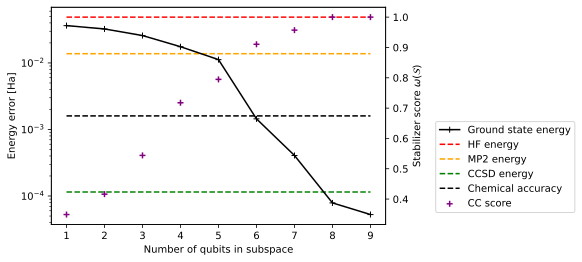

In [8]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_CC,Y_error = zip(*scores)

energy_axis.plot(X, Y_error, color='black', marker='+', label='Ground state energy')
energy_axis.hlines(molecule.hf_energy-molecule.fci_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy-molecule.fci_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy-molecule.fci_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy error [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.scatter(X, Y_CC, color='purple', label='CC score', marker='+')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()

# Bias the Hamiltonian around the HOMO-LUMO gap

The HOMO-LUMO gap lies between spin-orbitals 9 and 10


<BarContainer object of 14 artists>

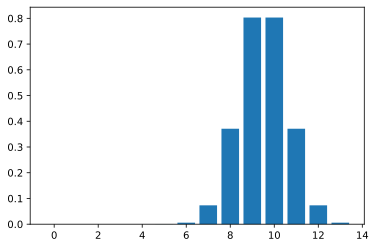

In [9]:
HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=molecule.H_q, HOMO_LUMO_gap=HL_gap)
CC_biasing  = ObservableBiasing(base_operator=molecule.T_q, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias  = 0.5
ham_biasing.LUMO_bias  = 0.5
ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(molecule.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

The HOMO-LUMO gap lies between spin-orbitals 5 and 6


<BarContainer object of 10 artists>

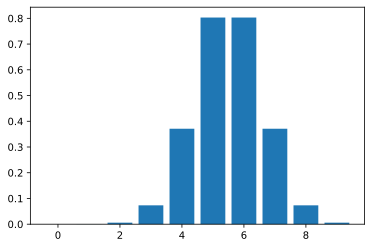

In [10]:
HL_gap = np.where(hf_tapered==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)
CC_biasing  = ObservableBiasing(base_operator=ucc_tap, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias  = 0.5
ham_biasing.LUMO_bias  = 0.5
ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(ham_tap.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

In [11]:
%%timeit

ham_biasing.HOMO_bias  = 0.2
ham_biasing.LUMO_bias  = 0.2
q=ham_tap.n_qubits//2
H_bias = ham_biasing.HOMO_LUMO_biased_operator()
stabilizers = StabilizerIdentification(H_bias)
S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=q)
stab_score = cs_vqe_lw.basis_score(S)

/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


15.2 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
heatmap_data={}
steps=10

avg_single = 15.2#ms
runtime_prediction = (avg_single/1000 * steps**2 * (ham_tap.n_qubits-1))/60
print(f'Predicted runtime: {runtime_prediction: .1f} minutes')
print()

for q in range(1, ham_tap.n_qubits):
    print(f'{q}-qubit')
    qubit_data = []
    for a in np.linspace(0, 1, steps):
        for b in np.linspace(0, 1, steps):
            ham_biasing.HOMO_bias = a
            ham_biasing.LUMO_bias = b
            H_bias = ham_biasing.HOMO_LUMO_biased_operator()
            #H_bias_tap = taper_hamiltonian.taper_it(
            #    aux_operator= H_bias, 
            #    ref_state=hf_array
            #)
            stabilizers = StabilizerIdentification(H_bias)
            S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=q)
            stab_score = cs_vqe_lw.basis_score(S)
            #ham_cs = cs_vqe_lw.project_onto_subspace(S)
            #matrix = ham_cs.to_sparse_matrix
            #e = exact_gs_energy(matrix)[0]
            #error = e-molecule.fci_energy

            qubit_data.append((a,b,stab_score))#,error))
        heatmap_data[q] = qubit_data

Predicted runtime:  0.2 minutes

1-qubit
2-qubit
3-qubit
4-qubit
5-qubit
6-qubit
7-qubit
8-qubit
9-qubit


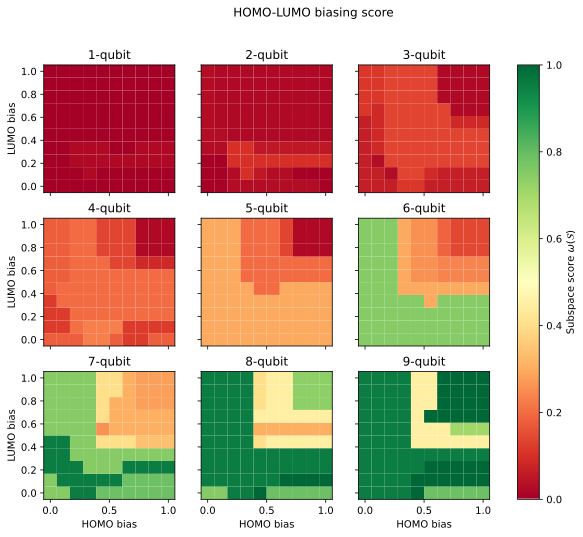

In [13]:
def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

n_rows,n_cols=factor_near_square(ham_tap.n_qubits-1)

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(10,8))

for q, data in list(heatmap_data.items()):
    i, j=(q-1)//n_cols, (q-1)%n_cols
    # generate 2 2d grids for the x & y bounds
    x,y,z_score = zip(*data)
    x = np.array(x).reshape(steps,steps)
    y = np.array(y).reshape(steps,steps)
    z_score = np.array(z_score).reshape(steps,steps)
    #z_error = np.array(z_error).reshape(steps,steps)
    
    c = axes[i, j].pcolormesh(
        x, y, z_score, cmap='RdYlGn', 
        vmin=0, vmax=1, shading='auto'
    )
    axes[i, j].set_title(f'{q}-qubit')
    # set the limits of the plot to the limits of the data
    #axes[i, j].axis([x.min(), x.max(), y.min(), y.max()])
    if i==n_rows-1:
        axes[i, j].set_xlabel('HOMO bias')
    if j==0:
        axes[i, j].set_ylabel('LUMO bias')

fig.colorbar(c, ax=axes, label='Subspace score $\omega(\mathcal{S})$')
fig.suptitle('HOMO-LUMO biasing score')
plt.show()

In [15]:
from scipy.optimize import minimize, differential_evolution, shgo, basinhopping, dual_annealing

def stabilizer_walk(n_sim_qubits, biasing_operator: HamiltonianBiasing):
    
    def get_stabilizers(x):
        biasing_operator.HOMO_bias,biasing_operator.LUMO_bias = x
        biased_op = biasing_operator.HOMO_LUMO_biased_operator()
        biased_op_tap = taper_hamiltonian.taper_it(aux_operator=biased_op, ref_state=hf_array)
        stabilizers = StabilizerIdentification(biased_op_tap)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits)
        return(S)
    
    def objective(x):
        S = get_stabilizers(x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = differential_evolution(objective, x0=[.5,.5], bounds=[(0,1),(0,1)])
    stab_score=-opt_out['fun']
    bias_param=opt_out['x']
    print(f'Optimal score w(S)={stab_score} for HOMO/LUMO bias {bias_param}')
    S=get_stabilizers(bias_param)
    return S

S_HL = stabilizer_walk(15, ham_biasing)

 1 ZIZZIIZIIZ 
 1 IZZIZIIZIZ 
 1 IIIIIZIIII

In [19]:
scores = []
HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = ObservableBiasing(base_operator=molecule.H_q, HOMO_LUMO_gap=HL_gap)

for i in range(1, ham_tap.n_qubits):
    print(i)
    ham_stabilizers = StabilizerIdentification(ham_tap)
    S_ham        = ham_stabilizers.symmetry_basis_by_subspace_dimension(i)
    S_ham_biased = stabilizer_walk(
        n_sim_qubits=i, 
        biasing_operator=ham_biasing, 
        cs_vqe_object=cs_vqe_lw,
        tapering_object=taper_hamiltonian,
        reference_state=hf_array)
    
    stab_score_ham = cs_vqe_lw.basis_score(S_ham)
    stab_score_ham_biased = cs_vqe_lw.basis_score(S_ham_biased)
    
    ham_cs = cs_vqe_lw.project_onto_subspace(S_ham)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    error = e-molecule.fci_energy
    
    ham_cs = cs_vqe_lw.project_onto_subspace(S_ham_biased)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    error_biased = e-molecule.fci_energy
    
    scores.append((stab_score_ham, stab_score_ham_biased, error, error_biased))

1


/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


2


KeyboardInterrupt: 

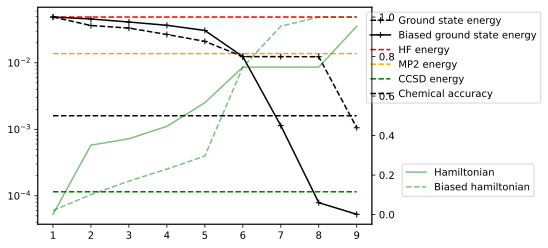

In [18]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_ham,Y_ham_biased,Y_error,Y_error_biased = zip(*scores)

energy_axis.plot(X, Y_error, color='black', marker='+', label='Ground state energy', ls='--')
energy_axis.plot(X, Y_error_biased, color='black', marker='+', label='Biased ground state energy')
energy_axis.hlines(molecule.hf_energy-molecule.fci_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy-molecule.fci_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy-molecule.fci_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
score_axis.plot(X, Y_ham, color='green', label='Hamiltonian', alpha=0.5)
score_axis.plot(X, Y_ham_biased, color='green', label='Biased hamiltonian', alpha=0.5, ls='--')

energy_axis.legend(ncol=1, bbox_to_anchor=(1.52,1))
score_axis.legend(ncol=1, bbox_to_anchor=(1.5,0.3))
plt.show()

In [226]:
X_block = molecule.T_q.X_block
X_op = PauliwordOp(
    np.hstack([X_block, np.zeros_like(X_block)]), 
    np.abs(molecule.T_q.coeff_vec)
).cleanup()
#X_op.coeff_vec = np.sum(X_op.X_block*CC_biasing.HOMO_LUMO_bias_curve(), axis=1)*X_op.coeff_vec
X_op

0.001+0.000j XXIIIIXXIIIIII +
0.002+0.000j IXXIIIXXIIIIII +
0.002+0.000j XIIXIIXXIIIIII +
0.027+0.000j IIXXIIXXIIIIII +
0.001+0.000j IIIIXXXXIIIIII +
0.001+0.000j XXIIIIIIXXIIII +
0.002+0.000j IXXIIIIIXXIIII +
0.002+0.000j XIIXIIIIXXIIII +
0.027+0.000j IIXXIIIIXXIIII +
0.001+0.000j IIIIXXIIXXIIII +
0.000+0.000j XIIIIIIIIIXIII +
0.005+0.000j IIXIIIIIIIXIII +
0.000+0.000j IXIIIIIIIIIXII +
0.005+0.000j IIIXIIIIIIIXII +
0.001+0.000j XXIIIIIIIIXXII +
0.000+0.000j IXXIIIIIIIXXII +
0.000+0.000j XIIXIIIIIIXXII +
0.028+0.000j IIXXIIIIIIXXII +
0.038+0.000j IIIIXXIIIIXXII +
0.002+0.000j IIIIXIIIIIIIXI +
0.000+0.000j XIIIXIIIIIXIXI +
0.003+0.000j IIXIXIIIIIXIXI +
0.000+0.000j IXIIXIIIIIIXXI +
0.023+0.000j IIIXXIIIIIIXXI +
0.000+0.000j XIIIIXIIIIIXXI +
0.020+0.000j IIXIIXIIIIIXXI +
0.002+0.000j IIIIIXIIIIIIIX +
0.000+0.000j IXIIXIIIIIXIIX +
0.020+0.000j IIIXXIIIIIXIIX +
0.000+0.000j XIIIIXIIIIXIIX +
0.023+0.000j IIXIIXIIIIXIIX +
0.000+0.000j IXIIIXIIIIIXIX +
0.003+0.000j IIIXIXIIIIIXIX +
0.001+0.00

In [227]:
biased_op==X_op

False

In [228]:
CC_biasing.HOMO_bias,CC_biasing.LUMO_bias = 0,0
biased_op = CC_biasing.HOMO_LUMO_biased_operator()
biased_op_tap = taper_hamiltonian.taper_it(aux_operator=biased_op, ref_state=hf_array)
stabilizers = StabilizerIdentification(biased_op_tap)
S = stabilizers.symmetry_basis_by_subspace_dimension(6)
S

/home/tweaving/anaconda3/lib/python3.8/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


 1 ZIZZZIZZI 
 1 IZZZZIZIZ 
 1 IIIIIZZZZ

In [229]:
X_op_tap = taper_hamiltonian.taper_it(aux_operator=X_op, ref_state=hf_array)
CC_stabilizers = StabilizerIdentification(X_op_tap)
S_CC         = CC_stabilizers.symmetry_basis_by_subspace_dimension(6)
print(S_CC)
print()
S_CC_biased  = stabilizer_walk(6, CC_biasing)
print(S_CC_biased)
stab_score_CC_biased  = cs_vqe_lw.basis_score(S_CC_biased)

ham_cs = cs_vqe_lw.project_onto_subspace(S_CC)
print(ham_cs.n_qubits)
matrix = ham_cs.to_sparse_matrix
e = exact_gs_energy(matrix)[0]
error = e-molecule.fci_energy
error

 1 ZIZZZIZZI 
 1 IZZZZIZIZ 
 1 IIIIIZZZZ

Optimal score w(S)=0.9842714253643332 for HOMO/LUMO bias [0.]
 1 ZIZZZIZZI 
 1 IZZZZIZIZ 
 1 IIIIIZZZZ
6


/home/tweaving/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:544: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


0.0008523478180997301

In [ ]:
def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

n_rows,n_cols=factor_near_square(ham_tap.n_qubits-1)

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(10,8))

for q, data in heatmap_data.items():
    i, j=(q-1)//n_cols, (q-1)%n_cols
    # generate 2 2d grids for the x & y bounds
    x,y,z_score,z_error = zip(*data)
    x = np.array(x).reshape(steps,steps)
    y = np.array(y).reshape(steps,steps)
    #z_score = np.array(z_score).reshape(steps,steps)
    z_error = np.array(z_error).reshape(steps,steps)
    
    c = axes[i, j].pcolormesh(
        x, y, z_error*1000, cmap='RdYlGn_r', 
        vmin=0, vmax=(molecule.hf_energy-molecule.fci_energy)*1000, shading='auto'
    )
    axes[i, j].set_title(f'{q}-qubit')
    # set the limits of the plot to the limits of the data
    #axes[i, j].axis([x.min(), x.max(), y.min(), y.max()])
    if i==n_rows-1:
        axes[i, j].set_xlabel('LUMO bias')
    if j==0:
        axes[i, j].set_ylabel('HOMO bias')

fig.colorbar(c, ax=axes, label='Absolute error [mHa]')
fig.suptitle('HOMO-LUMO biasing error')
plt.show()

In [17]:
# generate 2 2d grids for the x & y bounds
x,y,z_score,z_error = zip(*heatmap_data)
x = np.array(x).reshape(steps,steps)
y = np.array(y).reshape(steps,steps)
z_score = np.array(z_score).reshape(steps,steps)
z_error = np.array(z_error).reshape(steps,steps)

TypeError: 'int' object is not iterable

NameError: name 'z_error' is not defined

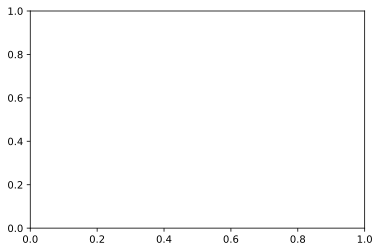

In [18]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_error, cmap='RdYlGn_r', vmin=0, vmax=z_error.max())
ax.set_title('Hamiltonian HOMO-LUMO biasing error')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

/tmp/ipykernel_89080/926170039.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(x, y, z_score, cmap='RdYlGn', vmin=0, vmax=1)


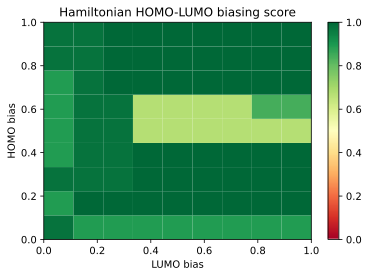

In [19]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_score, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title('Hamiltonian HOMO-LUMO biasing score')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

In [51]:
from scipy.optimize import minimize

def stabilizer_search(n_sim_qubits):
    
    def get_stabilizers(x):
        ham_biasing.HOMO_bias = x
        ham_biasing.LUMO_bias = x
        H_bias = taper_hamiltonian.taper_it(aux_operator=ham_biasing.HOMO_LUMO_biased_operator(), ref_state=hf_array)
        stabilizers = StabilizerIdentification(H_bias)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits)
        return(S)
    
    def objective(x):
        S = get_stabilizers(x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = minimize(objective, x0=[0], bounds=[(0,1)], method='POWELL')
    stab_score=-opt_out['fun']
    print(f'Optimal score w(S)={stab_score}')
    S=get_stabilizers(*opt_out['x'])
    return S

#plt.plot(bias_curve(np.arange(ham_tap.n_qubits), u_sig=np.pi/2, l_sig=np.pi/2,sep=10))
#stabs = stabilizer_search(20)
#print(stabs)

#ham_cs = cs_vqe_lw.project_onto_subspace(stabs)
#matrix = ham_cs.to_sparse_matrix
#e = exact_gs_energy(matrix)[0]
#error = e-fci_energy

#print(f'Energy error wrt FCI is {error} Ha')

In [52]:
scores = []

for i in range(1, ham_tap.n_qubits):
    print(i)
    S = stabilizer_search(i)
    stab_score = cs_vqe_lw.basis_score(S)
    scores.append(stab_score)

1
Optimal score w(S)=0.0032524888876650057
2
Optimal score w(S)=0.14198984105494494
3
Optimal score w(S)=0.3645574348851137
4
Optimal score w(S)=0.7660470324830356
5
Optimal score w(S)=0.5444808339282707
6
Optimal score w(S)=0.8638830809076047
7
Optimal score w(S)=0.9763728986065995
8
Optimal score w(S)=0.9999538429324424
9
Optimal score w(S)=0.9999724151786067


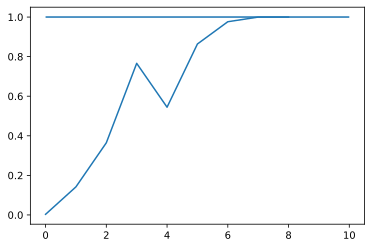

In [53]:
plt.plot(scores)
plt.hlines(1, 0, ham_tap.n_qubits)

In [94]:
ref_energy = fci_energy
max_sim_q = 10

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,hlg_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

1 did not work
2 did not work
3 did not work
4 did not work
5 did not work
6 did not work
7 did not work
8 did not work
9 did not work


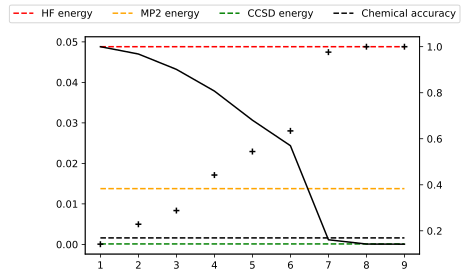

In [254]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [42]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
    
#scoring_data

In [43]:
#speciesname = 'H2O_6-31g_SINGLET'

#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [44]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [17]:
from scipy.special import comb

def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    ucc_stab_score = cs_vqe_lw.basis_score(S)
    ham_stab_score = cs_vqe_lw_2.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return ham_stab_score, ucc_stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(f'Randomizing {n_stabs} stabilizer(s)')
    count=0
    results = []
    while count<=2**ham_tap.n_qubits:
        try:
            results.append(score_vs_energy(n_stabs))
            count+=1
        except:
            pass
    data[ham_tap.n_qubits-n_stabs] = results

Randomizing 1 stabilizer(s)
Randomizing 2 stabilizer(s)
Randomizing 3 stabilizer(s)
Randomizing 4 stabilizer(s)
Randomizing 5 stabilizer(s)
Randomizing 6 stabilizer(s)
Randomizing 7 stabilizer(s)
Randomizing 8 stabilizer(s)


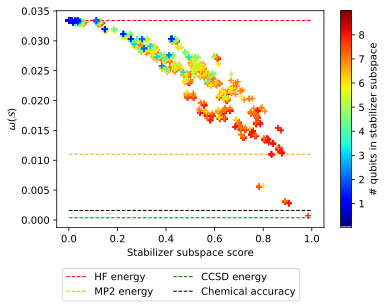

In [23]:
from matplotlib.pyplot import Normalize

fig,axis = plt.subplots()

increments = []

for n_qubits,results in data.items():
    ratio = n_qubits/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, Y = zip(*results)
    X = np.array(X_ucc)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=1,#n_qubits,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

In [31]:
#with open('data/score_vs_energy.json', 'r') as infile:
#    score_vs_energy = json.load(infile)
#    
#score_vs_energy.keys()

In [32]:
#score_vs_energy[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'ham_score_ucc_score_cs_energy':data
#}
#score_vs_energy

In [33]:
#with open('data/score_vs_energy.json', 'w') as outfile:
#    json.dump(score_vs_energy, outfile)